![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/open-source-nlp/04.0.NERDL_Training.ipynb)

# Named Entity Recognition (NER) DL Training

## Blogposts and videos:

https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77

NerDL worksghop (90 min): https://www.youtube.com/watch?v=YM-e4eOiQ34

https://medium.com/spark-nlp/named-entity-recognition-for-healthcare-with-sparknlp-nerdl-and-nercrf-a7751b6ad571

https://medium.com/atlas-research/ner-for-clinical-text-7c73caddd180

## Colab Setup

In [ ]:
!pip install -q pyspark==3.4.1  spark-nlp==5.1.2

In [2]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

spark = sparknlp.start()

print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

spark

Spark NLP version:  5.1.2
Apache Spark version:  3.4.1


## CoNLL Data Prep

`CoNLL(includeDocId=True).readDataset(spark, "conll_file.txt")`  this methos can allow if you have doc_id information in the conll file, you can add this information to the dataframe as a column.

```
conll="""-DOCSTART- -X- -1- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O

-DOCSTART- -X- 2 O

Rare NNP B-NP O
Hendrix NNP I-NP B-PER

-DOCSTART- -X- -3- O

China NNP B-NP B-LOC
says VBZ B-VP O

-DOCSTART-

China NNP B-NP B-LOC
says VBZ B-VP O
"""
```
```
with open('conll_file.txt', 'w') as f:
    f.write(conll)

data = CoNLL(includeDocId=True).readDataset(spark, "conll_file.txt")

data.show()
```



```
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|doc_id|                text|            document|            sentence|               token|                 pos|               label|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     1|EU rejects German...|[{document, 0, 28...|[{document, 0, 47...|[{token, 0, 1, EU...|[{pos, 0, 1, NNP,...|[{named_entity, 0...|
|     2|Rare Hendrix song...|[{document, 0, 97...|[{document, 0, 50...|[{token, 0, 3, Ra...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|
|     3|China says Taiwan...|[{document, 0, 13...|[{document, 0, 46...|[{token, 0, 4, Ch...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
|     X|China says Taiwan...|[{document, 0, 13...|[{document, 0, 46...|[{token, 0, 4, Ch...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
```

In [3]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.train
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.testa

In [4]:
with open("eng.train") as f:
    train_txt =f.read()

print (train_txt[:500])

-DOCSTART- -X- -X- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER

BRUSSELS NNP B-NP B-LOC
1996-08-22 CD I-NP O

The DT B-NP O
European NNP I-NP B-ORG
Commission NNP I-NP I-ORG
said VBD B-VP O
on IN B-PP O
Thursday NNP B-NP O
it PRP B-NP O
disagreed VBD B-VP O
with IN B-PP O
German JJ B-NP B-MISC
advice NN I-NP O
to TO B-PP O
consumers NNS B-NP


In [5]:
from sparknlp.training import CoNLL

training_data = CoNLL(includeDocId=True).readDataset(spark, './eng.train').limit(5000)

training_data.show(3)

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|doc_id|                text|            document|            sentence|               token|                 pos|               label|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     X|EU rejects German...|[{document, 0, 47...|[{document, 0, 47...|[{token, 0, 1, EU...|[{pos, 0, 1, NNP,...|[{named_entity, 0...|
|     X|     Peter Blackburn|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 4, Pe...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
|     X| BRUSSELS 1996-08-22|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 7, BR...|[{pos, 0, 7, NNP,...|[{named_entity, 0...|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [6]:
training_data.printSchema()

root
 |-- doc_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- document: array (nullable = false)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentence: array (nullable = false)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |--

In [7]:
training_data.cache()

DataFrame[doc_id: string, text: string, document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, sentence: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, token: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, pos: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, label: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>]

In [8]:
%time training_data.count()

CPU times: user 42.7 ms, sys: 5.04 ms, total: 47.7 ms
Wall time: 8.46 s


5000

In [9]:
import pyspark.sql.functions as F

training_data.select(F.explode(F.arrays_zip(training_data.token.result,
                                            training_data.pos.result,
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("pos"),
                     F.expr("cols['2']").alias("ner_label")).show(truncate=50)

+----------+---+---------+
|     token|pos|ner_label|
+----------+---+---------+
|        EU|NNP|    B-ORG|
|   rejects|VBZ|        O|
|    German| JJ|   B-MISC|
|      call| NN|        O|
|        to| TO|        O|
|   boycott| VB|        O|
|   British| JJ|   B-MISC|
|      lamb| NN|        O|
|         .|  .|        O|
|     Peter|NNP|    B-PER|
| Blackburn|NNP|    I-PER|
|  BRUSSELS|NNP|    B-LOC|
|1996-08-22| CD|        O|
|       The| DT|        O|
|  European|NNP|    B-ORG|
|Commission|NNP|    I-ORG|
|      said|VBD|        O|
|        on| IN|        O|
|  Thursday|NNP|        O|
|        it|PRP|        O|
+----------+---+---------+
only showing top 20 rows



In [10]:
training_data.select(F.explode(F.arrays_zip(training_data.token.result,
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+------------+-----+
|ground_truth|count|
+------------+-----+
|O           |55196|
|B-LOC       |2768 |
|B-PER       |2584 |
|B-ORG       |2058 |
|I-PER       |1875 |
|B-MISC      |1236 |
|I-ORG       |1105 |
|I-MISC      |455  |
|I-LOC       |357  |
+------------+-----+



In [11]:
# You can use any word embeddings you want (Glove, Elmo, Bert, custom etc.)

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
                      .setInputCols(["document", "token"])\
                      .setOutputCol("embeddings")


glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


# Create Graph

We will use `TFNerDLGraphBuilder` annotator to create a graph in the model training pipeline. This annotator inspects the data and creates the proper graph if a suitable version of TensorFlow (<= 2.11 ) is available. The graph is stored in the defined folder and loaded by the approach.

**ATTENTION:** Do not forget to play with the parameters of this annotator, it may affect the model performance that you want to train.



**Licensed users** would use this module to create **custom graphs** for each DL model (`ner_dl`, `generic_classifier`, `assertion_dl`, `relation_extraction`) in Spark NLP.

```
from sparknlp_jsl.training import tf_graph

tf_graph.build("ner_dl", build_params={"embeddings_dim": 200, "nchars": 80, "ntags": 12}, model_location="./", model_filename="auto")
```

In [ ]:
!pip install -q tensorflow==2.12.0
!pip install -q tensorflow-addons

In [13]:
!mkdir ner_logs
!mkdir ner_graphs

graph_folder = "./ner_graphs"

In [14]:
graph_builder = TFNerDLGraphBuilder()\
              .setInputCols(["sentence", "token", "embeddings"]) \
              .setLabelColumn("label")\
              .setGraphFile("auto")\
              .setGraphFolder(graph_folder)\
              .setHiddenUnitsNumber(20)

In [15]:
nerTagger = NerDLApproach()\
              .setInputCols(["sentence", "token", "embeddings"])\
              .setLabelColumn("label")\
              .setOutputCol("ner")\
              .setMaxEpochs(3)\
              .setLr(0.003)\
              .setBatchSize(32)\
              .setRandomSeed(0)\
              .setVerbose(1)\
              .setValidationSplit(0.2)\
              .setEvaluationLogExtended(True) \
              .setEnableOutputLogs(True)\
              .setIncludeConfidence(True)\
              .setGraphFolder(graph_folder)\
              .setOutputLogsPath('ner_logs') # if not set, logs will be written to ~/annotator_logs
          #   .setEnableMemoryOptimizer(True) # if not set, logs will be written to ~/annotator_logs

ner_pipeline = Pipeline(stages=[glove_embeddings,
                                graph_builder,
                                nerTagger])


### Fitting

In [16]:
%%time

ner_model = ner_pipeline.fit(training_data)

# 1 epoch takes around 3 min with batch size=32
# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook to create a graph (or see the bottom cell of this notebook)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
Instructions for updating:
non-resource variables are not supported in the long term


Ner DL Graph Builder configuration:
Graph folder: ./ner_graphs
Graph file name: auto
Build params: {'ntags': 9, 'embeddings_dim': 100, 'nchars': 84, 'lstm_size': 20}


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


CPU times: user 11.4 s, sys: 1.28 s, total: 12.7 s
Wall time: 1min 59s


In [17]:
import os

log_files = os.listdir("./ner_logs/")
log_files

['NerDLApproach_97167353f980.log']

In [18]:
with open("./ner_logs/"+log_files[0]) as log_file:
    print(log_file.read())

Name of the selected graph: /content/./ner_graphs/blstm_9_100_20_84.pb
Training started - total epochs: 3 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 83 - training examples: 3998


Epoch 1/3 started, lr: 0.003, dataset size: 3998


Epoch 1/3 - 20.73s - loss: 1005.6939 - batches: 127
Quality on validation dataset (20.0%), validation examples = 799
time to finish evaluation: 1.70s
label	 tp	 fp	 fn	 prec	 rec	 f1
B-LOC	 490	 452	 57	 0.52016985	 0.8957952	 0.6581598
I-ORG	 65	 27	 160	 0.70652175	 0.2888889	 0.41009462
I-MISC	 0	 0	 102	 0.0	 0.0	 0.0
I-LOC	 0	 0	 70	 0.0	 0.0	 0.0
I-PER	 375	 65	 29	 0.85227275	 0.9282178	 0.8886256
B-MISC	 26	 21	 227	 0.5531915	 0.1027668	 0.17333333
B-ORG	 219	 135	 186	 0.61864406	 0.5407407	 0.5770751
B-PER	 471	 95	 70	 0.83215547	 0.87061	 0.8509485
tp: 1646 fp: 795 fn: 901 labels: 8
Macro-average	 prec: 0.5103694, rec: 0.45337743, f1: 0.48018828
Micro-average	 prec: 0.6743138, rec: 0.6462505, f1: 0.65998393


Epoch 2/3 started, lr: 0.00298

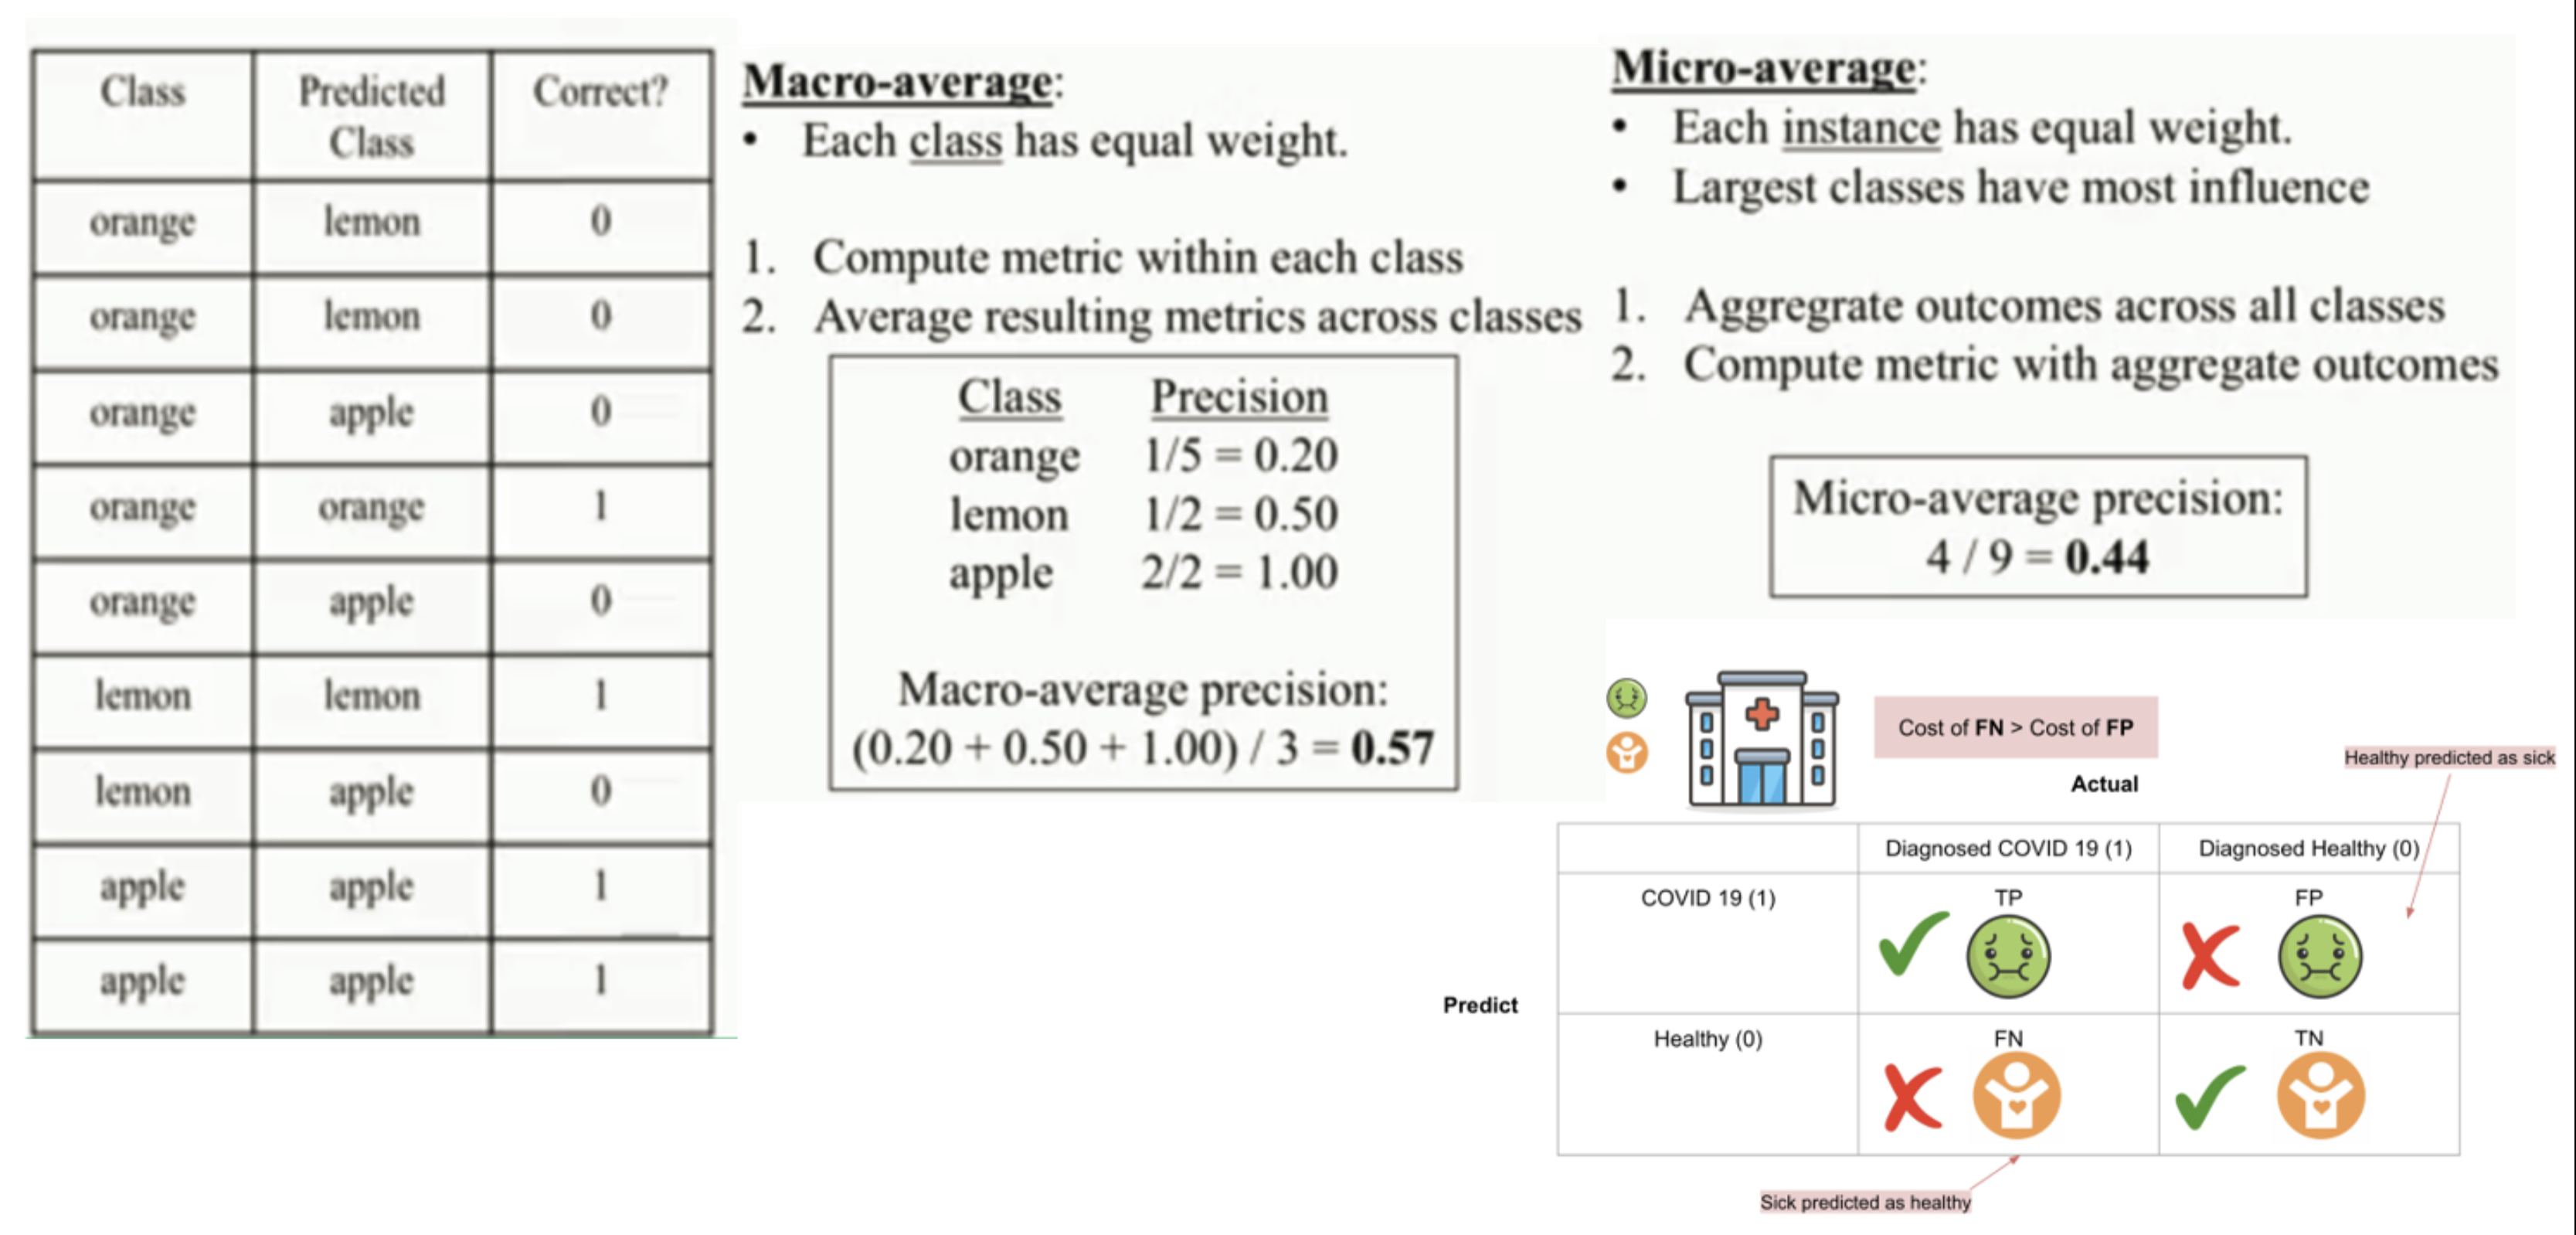

In [19]:
from sparknlp.training import CoNLL

test_data = CoNLL().readDataset(spark, './eng.testa').limit(1000)

test_data = glove_embeddings.transform(test_data)

test_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|          embeddings|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|CRICKET - LEICEST...|[{document, 0, 64...|[{document, 0, 64...|[{token, 0, 6, CR...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|[{word_embeddings...|
|   LONDON 1996-08-30|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 5, LO...|[{pos, 0, 5, NNP,...|[{named_entity, 0...|[{word_embeddings...|
|West Indian all-r...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 3, We...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|[{word_embeddings...|
+--------------------+--------------------+--------------------+--------------------+--------------------+

In [20]:
predictions = ner_model.transform(test_data)
predictions.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|          embeddings|                 ner|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|CRICKET - LEICEST...|[{document, 0, 64...|[{document, 0, 64...|[{token, 0, 6, CR...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
|   LONDON 1996-08-30|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 5, LO...|[{pos, 0, 5, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
|West Indian all-r...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 3, We...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{

In [21]:
predictions.select('token.result','label.result','ner.result').show(3, truncate=50)

+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|                                            result|                                            result|                                            result|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|[CRICKET, -, LEICESTERSHIRE, TAKE, OVER, AT, TO...|             [O, O, B-ORG, O, O, O, O, O, O, O, O]|             [O, O, B-ORG, O, O, O, O, O, O, O, O]|
|                              [LONDON, 1996-08-30]|                                        [B-LOC, O]|                                        [B-LOC, O]|
|[West, Indian, all-rounder, Phil, Simmons, took...|[B-MISC, I-MISC, O, B-PER, I-PER, O, O, O, O, O...|[B-ORG, B-MISC, O, B-PER, I-PER, O, O, O, O, O,...|
+--------------------------------------------------+------------------

### Test set evaluation

In [22]:
import pyspark.sql.functions as F

predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                          predictions.label.result,
                                          predictions.ner.result)).alias("cols")) \
            .select(F.expr("cols['0']").alias("token"),
                    F.expr("cols['1']").alias("ground_truth"),
                    F.expr("cols['2']").alias("prediction")).show(truncate=False)

+--------------+------------+----------+
|token         |ground_truth|prediction|
+--------------+------------+----------+
|CRICKET       |O           |O         |
|-             |O           |O         |
|LEICESTERSHIRE|B-ORG       |B-ORG     |
|TAKE          |O           |O         |
|OVER          |O           |O         |
|AT            |O           |O         |
|TOP           |O           |O         |
|AFTER         |O           |O         |
|INNINGS       |O           |O         |
|VICTORY       |O           |O         |
|.             |O           |O         |
|LONDON        |B-LOC       |B-LOC     |
|1996-08-30    |O           |O         |
|West          |B-MISC      |B-ORG     |
|Indian        |I-MISC      |B-MISC    |
|all-rounder   |O           |O         |
|Phil          |B-PER       |B-PER     |
|Simmons       |I-PER       |I-PER     |
|took          |O           |O         |
|four          |O           |O         |
+--------------+------------+----------+
only showing top

Licensed user will have an access to internal NERDLMetrics module to do this more efficient and easily without going out of Spark. But open source users need to use sklearn.metrics or any other equivalent module to do the same.

In [23]:
from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction']))


              precision    recall  f1-score   support

       B-LOC       0.85      0.91      0.88       559
      B-MISC       0.76      0.70      0.73       190
       B-ORG       0.79      0.72      0.75       355
       B-PER       0.93      0.96      0.95       654
       I-LOC       0.76      0.41      0.53        69
      I-MISC       0.96      0.25      0.39        93
       I-ORG       0.67      0.69      0.68       181
       I-PER       0.95      0.98      0.96       443
           O       0.99      0.99      0.99     11589

    accuracy                           0.97     14133
   macro avg       0.85      0.73      0.76     14133
weighted avg       0.97      0.97      0.96     14133



### Entity level evaluation (strict eval)

In [24]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/conll_eval.py

In [25]:
import conll_eval

metrics = conll_eval.evaluate(preds_df['ground_truth'].values, preds_df['prediction'].values)

processed 14133 tokens with 1758 phrases; found: 1795 phrases; correct: 1480.
accuracy:  83.88%; (non-O)
accuracy:  96.69%; precision:  82.45%; recall:  84.19%; FB1:  83.31
              LOC: precision:  82.39%; recall:  88.73%; FB1:  85.44  602
             MISC: precision:  66.86%; recall:  61.58%; FB1:  64.11  175
              ORG: precision:  70.62%; recall:  67.04%; FB1:  68.79  337
              PER: precision:  92.36%; recall:  96.18%; FB1:  94.23  681


In [26]:
# micro, macro, avg
metrics[0]

(82.45125348189416, 84.18657565415245, 83.30987897551367)

In [27]:
import pandas as pd

pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])

,entity,precision,recall,f1,support
0,LOC,82.392027,88.729875,85.443583,602
1,MISC,66.857143,61.578947,64.109589,175
2,ORG,70.623145,67.042254,68.786127,337
3,PER,92.364170,96.177370,94.232210,681


### Splitting Dataset Into Train and Test Set

Also we will use `.setTestDataset('ner_dl_test.parquet')` for checking test-loss values of each epoch in the logs file and `.useBestModel(True)` parameter whether to restore and use the model that has achieved the best performance at the end of the training. .



In [28]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, './eng.train')

(training_data, test_data) = conll_data.randomSplit([0.7, 0.3], seed = 100)

print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 9832
Test Dataset Count: 4209


In [29]:
!mkdir ner_logs_best

In [30]:
glove_embeddings.transform(test_data).write.parquet('ner_dl_test.parquet')

In [31]:
%%time
nerTagger = NerDLApproach()\
              .setInputCols(["sentence", "token", "embeddings"])\
              .setLabelColumn("label")\
              .setOutputCol("ner")\
              .setMaxEpochs(5)\
              .setLr(0.003)\
              .setBatchSize(32)\
              .setRandomSeed(0)\
              .setVerbose(1)\
              .setValidationSplit(0.2)\
              .setEvaluationLogExtended(True) \
              .setEnableOutputLogs(True)\
              .setIncludeConfidence(True)\
              .setUseBestModel(True)\
              .setGraphFolder(graph_folder)\
              .setTestDataset('ner_dl_test.parquet')\
              .setOutputLogsPath('ner_logs_best') # if not set, logs will be written to ~/annotator_logs

ner_pipeline = Pipeline(stages=[glove_embeddings,
                                graph_builder,
                                nerTagger])


ner_model = ner_pipeline.fit(training_data)

Ner DL Graph Builder configuration:
Graph folder: ./ner_graphs
Graph file name: auto
Build params: {'ntags': 9, 'embeddings_dim': 100, 'nchars': 85, 'lstm_size': 20}


/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


CPU times: user 6.62 s, sys: 220 ms, total: 6.84 s
Wall time: 5min 16s


In [32]:
log_files = os.listdir("./ner_logs_best/")
log_files

['NerDLApproach_f5c327d6e04c.log']

In [33]:
with open("./ner_logs_best/"+log_files[0]) as log_file:
    print(log_file.read())

Name of the selected graph: /content/./ner_graphs/blstm_9_100_20_85.pb
Training started - total epochs: 5 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 84 - training examples: 7921


Epoch 1/5 started, lr: 0.003, dataset size: 7921


Epoch 1/5 - 39.79s - loss: 1434.7059 - batches: 249
Quality on validation dataset (20.0%), validation examples = 1584
time to finish evaluation: 4.00s
label	 tp	 fp	 fn	 prec	 rec	 f1
B-LOC	 884	 186	 128	 0.82616824	 0.8735178	 0.8491835
I-ORG	 305	 90	 198	 0.7721519	 0.6063618	 0.6792873
I-MISC	 59	 44	 79	 0.57281554	 0.42753622	 0.48962653
I-LOC	 102	 51	 74	 0.6666667	 0.57954544	 0.62006074
I-PER	 629	 54	 21	 0.92093706	 0.9676923	 0.94373596
B-MISC	 315	 117	 143	 0.7291667	 0.6877729	 0.7078651
B-ORG	 592	 167	 270	 0.7799736	 0.68677497	 0.7304133
B-PER	 891	 98	 59	 0.90091	 0.93789476	 0.9190305
tp: 3777 fp: 807 fn: 972 labels: 8
Macro-average	 prec: 0.7710987, rec: 0.72088706, f1: 0.74514794
Micro-average	 prec: 0.82395285, rec: 0.7953253

In [34]:
test_data = glove_embeddings.transform(test_data)

predictions = ner_model.transform(test_data)

from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction'], digits=4))


              precision    recall  f1-score   support

       B-LOC     0.9012    0.9471    0.9236      2100
      B-MISC     0.8755    0.8317    0.8530       998
       B-ORG     0.8796    0.8409    0.8598      1929
       B-PER     0.9258    0.9559    0.9406      1905
       I-LOC     0.7833    0.8418    0.8115       335
      I-MISC     0.7479    0.5974    0.6642       303
       I-ORG     0.8683    0.8277    0.8475      1155
       I-PER     0.9602    0.9731    0.9666      1340
           O     0.9946    0.9953    0.9950     51332

    accuracy                         0.9785     61397
   macro avg     0.8818    0.8679    0.8735     61397
weighted avg     0.9782    0.9785    0.9783     61397



### Ner log parser

In [35]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py

In [36]:
import ner_log_parser
%matplotlib inline

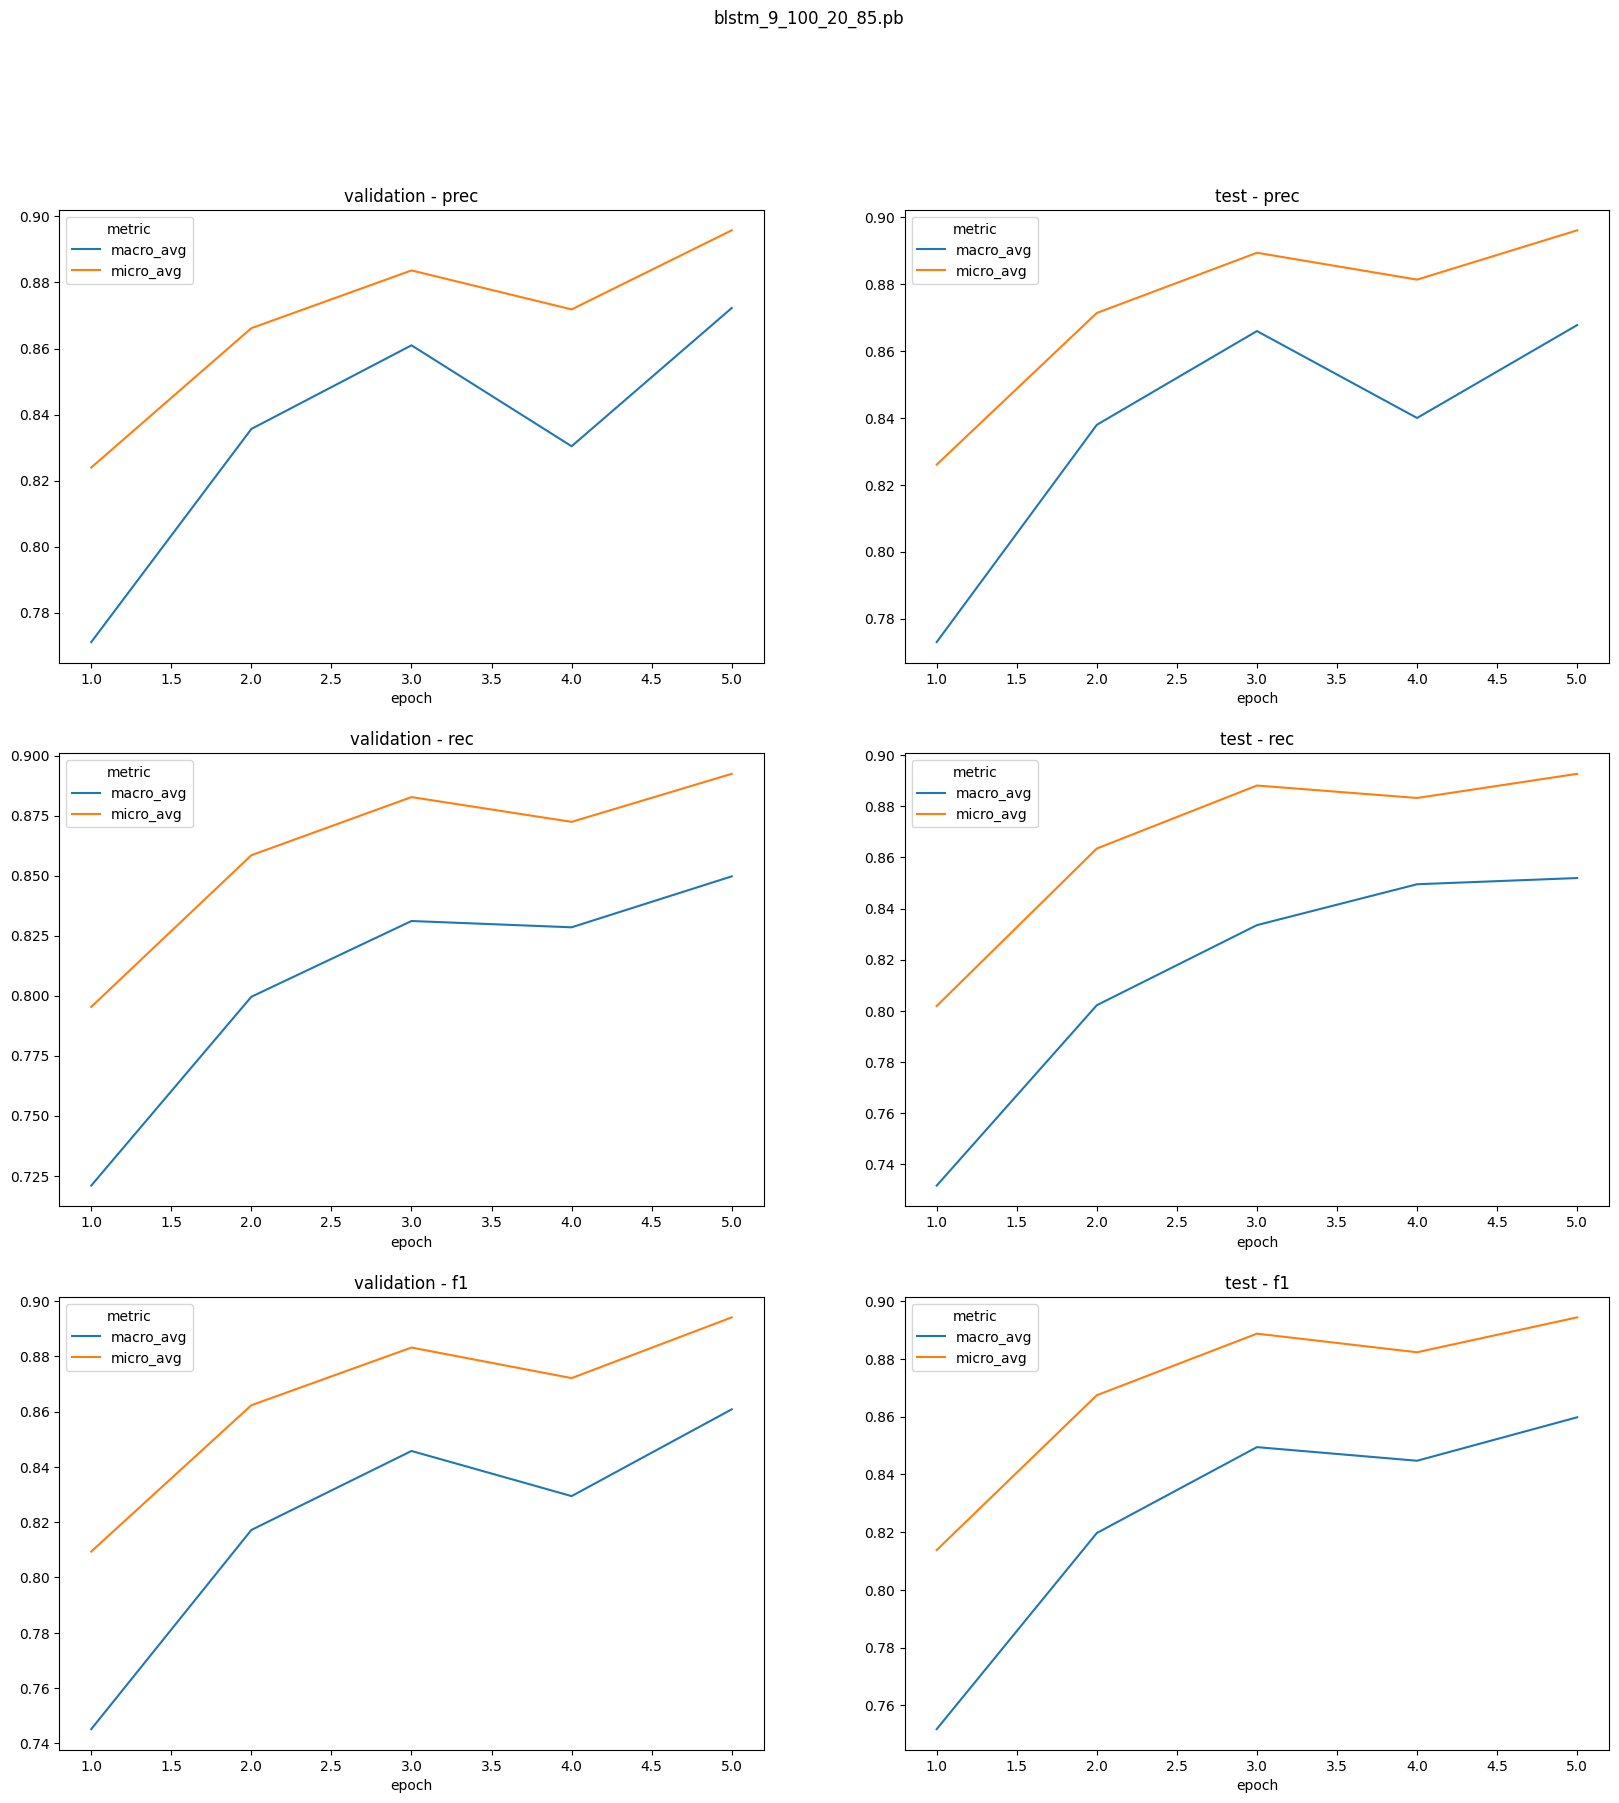

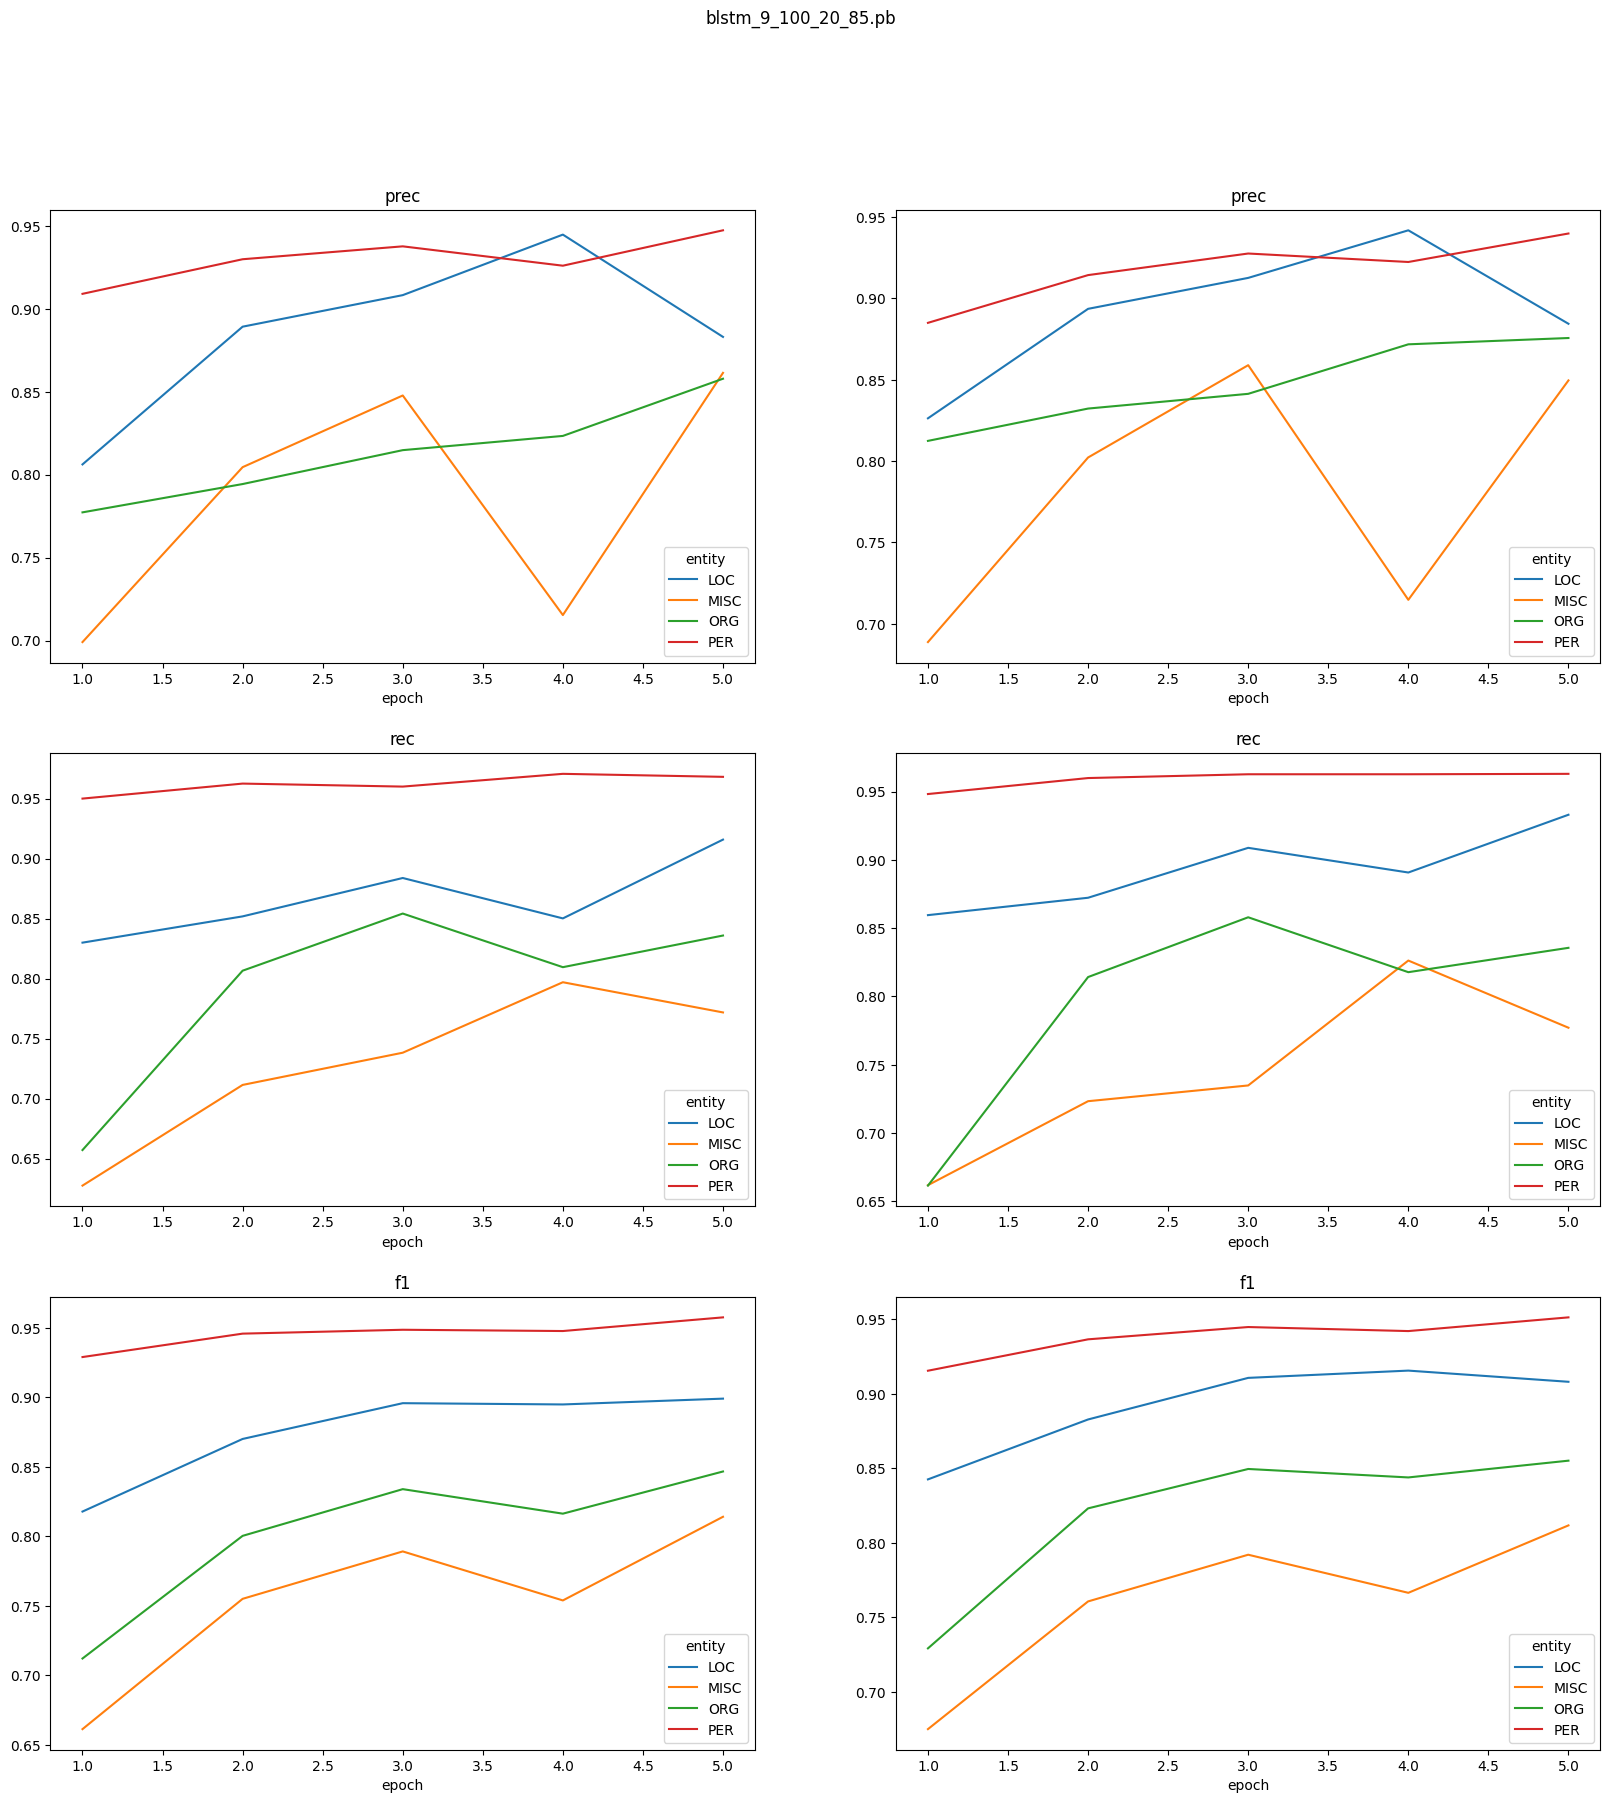

In [37]:
ner_log_parser.get_charts('./ner_logs_best/'+log_files[0])

**Plotting Loss**

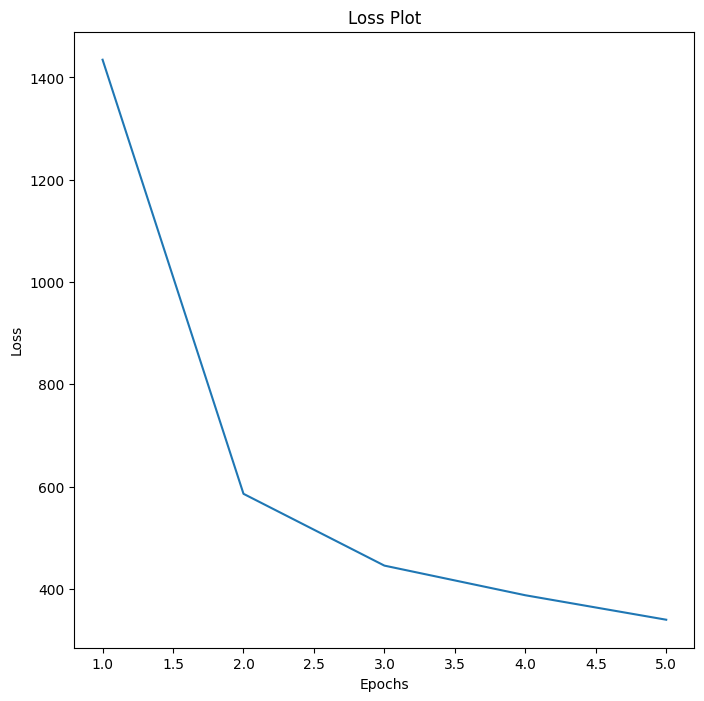

In [38]:
ner_log_parser.loss_plot('./ner_logs_best/'+log_files[0])

### Saving the trained model

In [39]:
ner_model.stages

[WORD_EMBEDDINGS_MODEL_48cffc8b9a76,
 TFNerDLGraphBuilderModel_2795c99d473c,
 NerDLModel_e7a9f51f3536]

In [40]:
ner_model.stages[-1].write().overwrite().save('NER_glove_e5_b32')

In [41]:
!ls -lt

total 4060
drwxr-xr-x 4 root root    4096 Oct  4 01:37 NER_glove_e5_b32
drwxr-xr-x 2 root root    4096 Oct  4 01:37 __pycache__
-rw-r--r-- 1 root root    3826 Oct  4 01:37 ner_log_parser.py
drwxr-xr-x 2 root root    4096 Oct  4 01:32 ner_logs_best
drwxr-xr-x 2 root root    4096 Oct  4 01:31 ner_graphs
drwxr-xr-x 2 root root    4096 Oct  4 01:31 ner_dl_test.parquet
-rw-r--r-- 1 root root    7431 Oct  4 01:28 conll_eval.py
drwxr-xr-x 2 root root    4096 Oct  4 01:26 ner_logs
-rw-r--r-- 1 root root  827443 Oct  4 01:23 eng.testa
-rw-r--r-- 1 root root 3283420 Oct  4 01:23 eng.train
drwxr-xr-x 1 root root    4096 Oct  2 13:21 sample_data


## Prediction Pipeline

In [42]:
document = DocumentAssembler()\
            .setInputCol("text")\
            .setOutputCol("document")

sentence = SentenceDetector()\
            .setInputCols(['document'])\
            .setOutputCol('sentence')

token = Tokenizer()\
            .setInputCols(['sentence'])\
            .setOutputCol('token')

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
            .setInputCols(["document", "token"])\
            .setOutputCol("embeddings")

# load trained model
loaded_ner_model = NerDLModel.load("NER_glove_e5_b32")\
            .setInputCols(["sentence", "token", "embeddings"])\
            .setOutputCol("ner")

converter = NerConverter()\
            .setInputCols(["document", "token", "ner"])\
            .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(
    stages = [
        document,
        sentence,
        token,
        glove_embeddings,
        loaded_ner_model,
        converter
        ])

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [43]:
empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)

In [44]:
text = "Peter Parker is a nice guy and lives in New York."

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=False)

+-------------------------------------------------+
|text                                             |
+-------------------------------------------------+
|Peter Parker is a nice guy and lives in New York.|
+-------------------------------------------------+



In [45]:
preds = prediction_model.transform(sample_data)

preds.select(F.explode(F.arrays_zip(preds.ner_span.result,
                                    preds.ner_span.metadata)).alias("entities")) \
      .select(F.expr("entities['0']").alias("chunk"),
              F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

+------------+------+
|chunk       |entity|
+------------+------+
|Peter Parker|PER   |
|New York    |LOC   |
+------------+------+



In [46]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

In [47]:
text = "Peter Parker is a nice guy and lives in New York."

result = light_model.annotate(text)

list(zip(result['token'], result['ner']))

[('Peter', 'B-PER'),
 ('Parker', 'I-PER'),
 ('is', 'O'),
 ('a', 'O'),
 ('nice', 'O'),
 ('guy', 'O'),
 ('and', 'O'),
 ('lives', 'O'),
 ('in', 'O'),
 ('New', 'B-LOC'),
 ('York', 'I-LOC'),
 ('.', 'O')]

In [48]:
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])],
                      columns=['sent_id','token','start','end','ner'])
ner_df

,sent_id,token,start,end,ner
0,0,Peter,0,4,B-PER
1,0,Parker,6,11,I-PER
2,0,is,13,14,O
3,0,a,16,16,O
4,0,nice,18,21,O
5,0,guy,23,25,O
6,0,and,27,29,O
7,0,lives,31,35,O
8,0,in,37,38,O
9,0,New,40,42,B-LOC


### **Highlight Entities**

In [ ]:
! pip install -q spark-nlp_display

In [50]:
from sparknlp.pretrained import PretrainedPipeline

pipeline = PretrainedPipeline('recognize_entities_dl', lang='en')

recognize_entities_dl download started this may take some time.
Approx size to download 159 MB
[OK!]


In [51]:
ann_text = pipeline.fullAnnotate('Peter Parker is a nice persn and lives in New York. Bruce Wayne is also a nice guy and lives in Gotham City.')[0]
ann_text.keys()

dict_keys(['entities', 'document', 'token', 'ner', 'embeddings', 'sentence'])

In [52]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()
print ('Standard Output')
visualiser.display(ann_text, label_col='entities', document_col='document')

# Change color of an entity label
visualiser.set_label_colors({'LOC':'#008080', 'PER':'#800080'})
visualiser.display(ann_text, label_col='entities')

# Set label filter
visualiser.display(ann_text, label_col='entities', document_col='document',
                   labels=['PER'])

print ('\nColor code for label: \n"LOC": {}\n"PER": {}' .format(visualiser.get_label_color('LOC'),visualiser.get_label_color('PER')) )

Standard Output



Color code for label: 
"LOC": #008080
"PER": #800080


# Creating Your Own CoNLL dataset

for a detailed overview of how to create a CoNLL file from any annotation, see here >> https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.3.prepare_CoNLL_from_annotations_for_NER.ipynb


In [53]:
import json
import os
from pyspark.ml import Pipeline
from sparknlp.base import *
from sparknlp.annotator import *
import sparknlp

spark = sparknlp.start()

def get_ann_pipeline ():

    document_assembler = DocumentAssembler() \
              .setInputCol("text")\
              .setOutputCol('document')

    sentencer = SentenceDetector()\
              .setInputCols(['document'])\
              .setOutputCol('sentence')

    tokenizer = Tokenizer() \
              .setInputCols(["sentence"]) \
              .setOutputCol("token")

    pos = PerceptronModel.pretrained() \
              .setInputCols(["sentence", "token"]) \
              .setOutputCol("pos")

    embeddings = WordEmbeddingsModel.pretrained()\
              .setInputCols(["sentence", "token"])\
              .setOutputCol("embeddings")

    ner_model = NerDLModel.pretrained() \
              .setInputCols(["sentence", "token", "embeddings"]) \
              .setOutputCol("ner")

    ner_converter = NerConverter()\
              .setInputCols(["sentence", "token", "ner"])\
              .setOutputCol("ner_chunk")

    ner_pipeline = Pipeline(stages = [document_assembler,
                                      sentencer,
                                      tokenizer,
                                      pos,
                                      embeddings,
                                      ner_model,
                                      ner_converter])

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    ner_pipelineFit = ner_pipeline.fit(empty_data)

    ner_lp_pipeline = LightPipeline(ner_pipelineFit)

    print ("Spark NLP NER lightpipeline is created")

    return ner_lp_pipeline


conll_pipeline = get_ann_pipeline ()


pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[OK!]
Spark NLP NER lightpipeline is created


In [54]:
sentences = ["Peter Parker is a nice guy and lives in New York.",
             "He is also helping people around the world."]

conll_lines=''

for sentence in sentences:

  parsed = conll_pipeline.annotate (sentence)

  for token, pos, ner in zip(parsed['token'],parsed['pos'],parsed['ner']):

      conll_lines += "{} {} {} {}\n".format(token, pos, pos, ner)

  conll_lines += '\n'


print(conll_lines)

Peter NNP NNP B-PER
Parker NNP NNP I-PER
is VBZ VBZ O
a DT DT O
nice JJ JJ O
guy NN NN O
and CC CC O
lives NNS NNS O
in IN IN O
New NNP NNP B-LOC
York NNP NNP I-LOC
. . . O

He PRP PRP O
is VBZ VBZ O
also RB RB O
helping VBG VBG O
people NNS NNS O
around IN IN O
the DT DT O
world NN NN O
. . . O


